In [78]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from tqdm import tqdm

pd.set_option("display.max_columns", 500)
plt.style.use("dark_background")

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Get data

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/madhurpant/world-deaths-and-causes-1990-2019"
)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  lukechesley


Your Kaggle Key:

  ········


100%|███████████████████████████████████████████████████████████████████████████████| 442k/442k [00:00<00:00, 2.89MB/s]

In [14]:
od.download('https://www.kaggle.com/datasets/iamsouravbanerjee/world-population-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  lukechesley


Your Kaggle Key:

  ········


100%|██████████████████████████████████████████████████████████████████████████████| 15.7k/15.7k [00:00<00:00, 447kB/s]

# Start

In [91]:
df = pd.read_csv(
    r"C:\Users\Luke Chesley\jupyterlab/world-deaths-and-causes-1990-2019/annual_deaths_by_causes.csv"
)
df_pop = pd.read_csv(
    r"C:\Users\Luke Chesley\jupyterlab/world-population-dataset/world_population.csv"
)

In [92]:
df_pop = df_pop.rename({"Country/Territory": "country"}, axis=1)

In [5]:
df_pop.query(f'country == "Albania"')["2022 Population"]

1    2842321
Name: 2022 Population, dtype: int64

# add population to df from df_pop

In [93]:
year_groups = [
    (df["year"] >= 1990) & (df["year"] < 2000),
    (df["year"] >= 2000) & (df["year"] < 2010),
    (df["year"] >= 2010) & (df["year"] < 2015),
    (df["year"] >= 2015) & (df["year"] < 2020),
]
values = ["1990 Population", "2000 Population", "2010 Population", "2015 Population"]

df["year_group"] = np.select(year_groups, values)
df["population"] = ""

In [94]:
for n in range(len(df)):
    countr = df["country"][n]
    if countr in list(df_pop["country"]):
        year_group = df["year_group"][n]
        pop = df_pop.loc[df_pop["country"] == countr][year_group]
        pop = int(pop)
        df["population"][n] = pop

    else:
        pass

C:\Users\Luke Chesley\AppData\Local\Temp\ipykernel_19576\3567703202.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["population"][n] = pop


# Drop non countries

In [42]:
countries_to_drop = [
    "African Region (WHO)",
    "Australasia & Oceania",
    "Antigua and Barbuda",
    "American Samoa",
    "Bahamas",
    "Bahrain",
    "Central America & Caribbean",
    "Central Asia",
    "Cook Islands",
    "Dominica",
    "Europe & Central Asia (WB)",
    "European Region (WHO)",
    "G20",
    "Malta",
    "Marshall Islands",
    "Middle East & North Africa (WB)",
    "Monaco",
    "Nauru",
    "Niue",
    "North America (WB)",
    "Northern Mariana Islands",
    "OECD Countries",
    "Palau",
    "Region of the Americas (WHO)",
    "Saint Kitts and Nevis",
    "San Marino",
    "South Asia (WB)",
    "South-East Asia Region (WHO)",
    "Sub-Saharan Africa (WB)",
    "Tokelau",
    "Tuvalu",
    "Western Pacific Region (WHO)",
    "World",
    "World Bank High Income",
    "World Bank Low Income",
    "World Bank Lower Middle Income",
    "World Bank Upper Middle Income",
    "Andorra",
    "East Asia",
    "East Asia & Pacific (WB)",
    "Latin America & Caribbean (WB)",
    "World (excluding China)",
]

In [43]:
df = df[~df["country"].isin(countries_to_drop)]

# fillna

In [95]:
df = df.fillna(0)

# get drownings for each country in a df

Relavant cols from df

In [48]:
df_drown = df[["year", "country", "drowning"]]

Sort by country and year

In [49]:
df_drown = (
    df_drown.sort_values(by=["country", "year"]).reset_index().drop("index", axis=1)
)

Initalize df so it can be concatted too, probabaly a better way to do this

In [50]:
step1 = df_drown.loc[df_drown["country"] == "Afghanistan"]
starter = (
    step1.set_index("year")
    .drop("country", axis=1)
    .rename({"drowning": "Afghanistan"}, axis=1)
)

In [51]:
country_list = df_drown.country.unique()

create df_drown

In [14]:
for country in country_list:
    df2_0 = df_drown.loc[df_drown["country"] == country]
    df_2_1 = (
        df2_0.set_index("year")
        .drop("country", axis=1)
        .rename({"drowning": country}, axis=1)
    )

    starter = pd.concat([starter, df_2_1], axis=1)

df_drown = starter

Clean up df_drown

In [15]:
df_drown = df_drown.dropna(axis=1)

Create pop_df with same shape as df_drown and remove duplicate cols

In [16]:
pop_df = pd.DataFrame(columns=df_drown.columns, index=df_drown.index)
pop_df = pop_df.loc[:, ~pop_df.columns.duplicated()].copy()
df_drown = df_drown.loc[:, ~df_drown.columns.duplicated()].copy()

Set values in pop_df by looking up relavant value from df

In [17]:
for country in pop_df.columns:
    for n in range(1990, 2020):
        pop_df[country][n] = df.loc[(df["year"] == n) & (df["country"] == country)][
            "population"
        ].values[0]

drop cols with no drowning data

In [18]:
drop = []
for n in pop_df.columns:
    if pop_df[n].sum() == "":
        drop.append(n)

In [19]:
pop_df = pop_df.drop(drop, axis=1)
df_drown = df_drown.drop(drop, axis=1)

Change type to float

In [20]:
pop_df = pop_df.astype("float64")

Create drown_pop_df which is  drownings per captia

In [21]:
drown_pop_df = df_drown / pop_df

Graph drown_pop_df

In [22]:
# drown_pop_df.plot.line(figsize=(24, 14))
# plt.legend(
#    bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize="x-small"
# )

Above graph too busy, limit to 10 countries based on conditions

countries with highest drownings in 1990

In [23]:
highest_drownings = (
    drown_pop_df.loc[drown_pop_df.index == 1990]
    .max()
    .sort_values(ascending=False)[0:11]
    .keys()
    .to_list()
)

[Text(1992.5375, 0.0003226745960114421, 'Bangladesh'),
 Text(1994.93, 0.00021587127026852565, 'Haiti'),
 Text(1997.3225, 0.00018537853132959435, 'Cambodia'),
 Text(1999.715, 0.0001427515580941975, 'Laos'),
 Text(2002.1075, 0.00022584295010442411, 'Solomon Islands'),
 Text(2004.5, 0.00012019544325865954, 'Myanmar'),
 Text(2006.8925, 6.371523537469868e-05, 'Maldives'),
 Text(2009.285, 7.009342351826818e-05, 'Nepal'),
 Text(2011.6775, 7.561276784057326e-05, 'Latvia'),
 Text(2014.07, 6.999697032644108e-05, 'Vietnam'),
 Text(2016.4625, 2.2904115214419425e-05, 'Turkmenistan')]

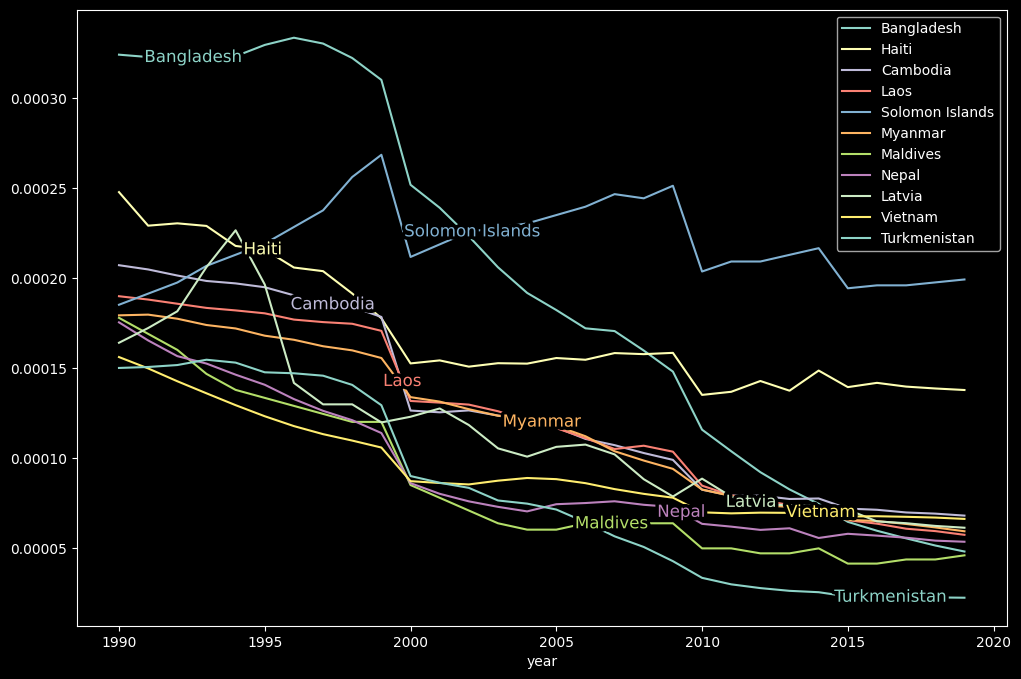

In [24]:
drown_pop_df[highest_drownings].plot.line(figsize=(12, 8))
labelLines(align=False, fontsize=12)

Add lines at 1999 and 2000 to highlight steep drop

In [25]:
# drown_pop_df.loc[(drown_pop_df.index >= 1995) & (drown_pop_df.index <= 2003)][
#    highest_drownings
# ].plot.line(figsize=(12, 8))
# labelLines(align=False, fontsize=12)
# plt.axvline(x=1999)
# plt.axvline(x=2000)

Create df to show the change year over year with same shape as before

In [26]:
# drown_pop_change_df = pd.DataFrame(
#    columns=drown_pop_df.columns, index=drown_pop_df.index
# )

Loop through and set each data point

In [27]:
# for country in drown_pop_df.columns:
#    for n in range(1991, 2020):
#        drown_pop_change_df[country][n] = (
#            drown_pop_df[country][n] - drown_pop_df[country][n - 1]
#        ) / drown_pop_df[country][n - 1]

Plot

In [28]:
# drown_pop_change_df.plot.line(figsize=(12, 8), title="% Change in # of Drownings")
# plt.legend(
#    bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize="x-small"
# )

limit to 10 worst countires

In [35]:
# drown_pop_change_df[highest_drownings].plot.line(figsize=(12, 8))

# Try to do the above process for each cause of death

In [33]:
list_of_causes = df.drop(
    ["country", "code", "year", "year_group", "population"], axis=1
).columns.to_list()

  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

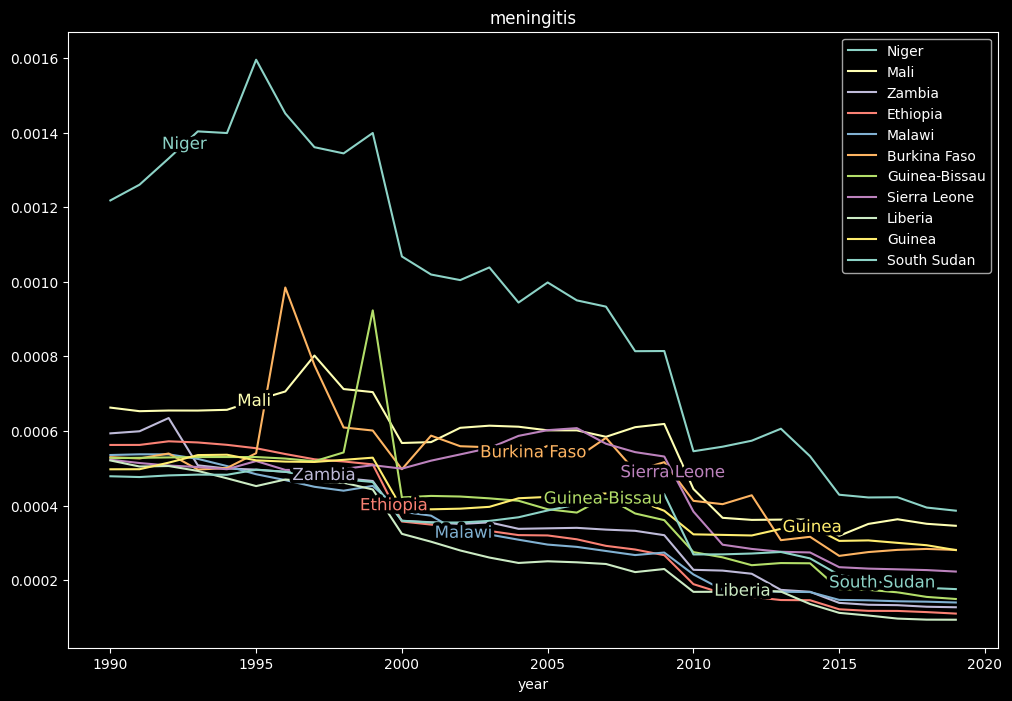

  3%|██▌                                                                                | 1/32 [00:07<03:37,  7.00s/it]

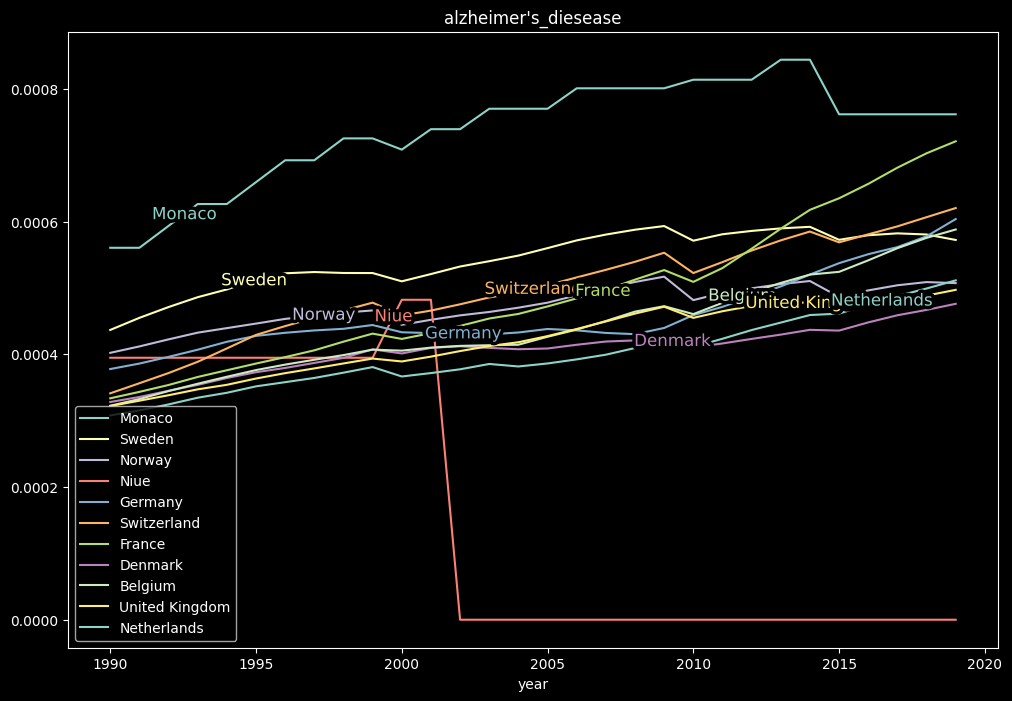

  6%|█████▏                                                                             | 2/32 [00:15<03:49,  7.66s/it]

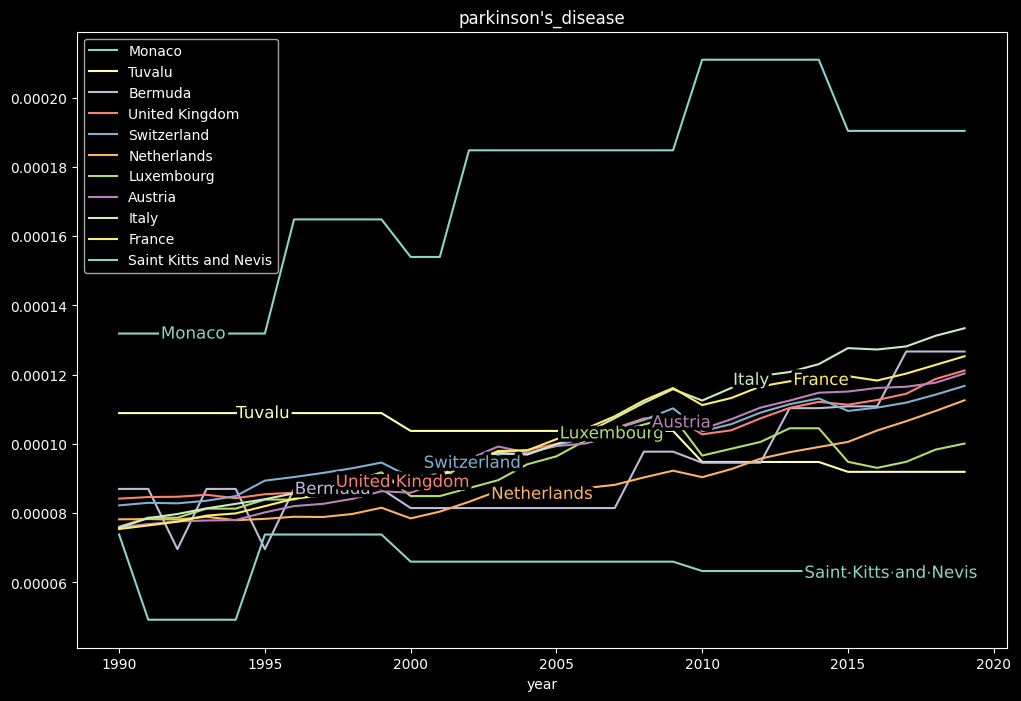

  9%|███████▊                                                                           | 3/32 [00:22<03:40,  7.59s/it]

In [ ]:
for cause in tqdm(list_of_causes):
    df_cause = df[["year", "country", cause]]
    df_cause = (
        df_cause.sort_values(by=["country", "year"]).reset_index().drop("index", axis=1)
    )
    step1 = df_cause.loc[df_cause["country"] == "Afghanistan"]
    starter = (
        step1.set_index("year")
        .drop("country", axis=1)
        .rename({cause: "Afghanistan"}, axis=1)
    )

    pass

    country_list = df_cause.country.unique()

    pass

    for country in country_list:
        df2_0 = df_cause.loc[df_cause["country"] == country]
        df_2_1 = (
            df2_0.set_index("year")
            .drop("country", axis=1)
            .rename({cause: country}, axis=1)
        )

        starter = pd.concat([starter, df_2_1], axis=1)

    df_cause = starter

    df_cause = df_cause.dropna(axis=1)

    pop_df = pd.DataFrame(columns=df_cause.columns, index=df_cause.index)

    pop_df = pop_df.loc[:, ~pop_df.columns.duplicated()].copy()
    df_cause = df_cause.loc[:, ~df_cause.columns.duplicated()].copy()

    for x in pop_df.columns:
        for n in range(1990, 2020):
            pop_df[x][n] = df.loc[(df["year"] == n) & (df["country"] == x)][
                "population"
            ].values[0]

    drop = []
    for n in pop_df.columns:
        if pop_df[n].sum() == "":
            drop.append(n)

    pop_df = pop_df.drop(drop, axis=1)
    df_cause = df_cause.drop(drop, axis=1)
    pop_df = pop_df.astype("float64")

    cause_pop_df = df_cause / pop_df

    highest_deaths = (
        cause_pop_df.loc[cause_pop_df.index == 1990]
        .max()
        .sort_values(ascending=False)[0:11]
        .keys()
        .to_list()
    )

    cause_pop_df[highest_deaths].plot.line(figsize=(12, 8), title=cause)
    labelLines(align=False, fontsize=12)
    plt.show()